In [2]:
import sys
sys.path.append('/home/bw/code/caffe/python')
import caffe
import dicom
import datetime
# return paitent X pixel array(numpy ndarray) and age(int)
def getPaientInfo(filename):
    info = []
    ds = dicom.read_file(filename)
    pixelArray = ds.pixel_array
    info.append(pixelArray)
    birthDate = ds.PatientBirthDate
    studyDate = ds.StudyDate
    bDate = birthDate[0:4]+'-'+birthDate[4:6]+'-'+birthDate[6:8]
    sDate = studyDate[0:4]+'-'+studyDate[4:6]+'-'+studyDate[6:8]
    bd = datetime.datetime.strptime(bDate, '%Y-%m-%d')
    sd = datetime.datetime.strptime(sDate, '%Y-%m-%d')
    days = (sd-bd).days
    age = int(round(days/365))
    info.append(age)
    return info

In [3]:
import random
import os
# this function export the data file list 
def getFileList(root_dir):
    file_list = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            file_dir = root + '/' + file
#             print file_dir
            file_list.append(file_dir)
    random.shuffle(file_list)
    return file_list

In [3]:
from skimage.transform import resize
# the function will resize the data array to width and height together
def resizeDicomArray(pixel_array):
    height, width = pixel_array.shape
    if height<width:
        pixel_array = pixel_array[:, (width-height)/2:(width+height)/2]
    else:
        pixel_array = pixel_array[(height-width)/2:(width+height)/2, :]
    pixel_array = resize(pixel_array, (256, 256))
    return pixel_array

In [8]:
import dicom
import pylab
# the function shwo a pixel from an numpy ndarray
def showImage(pixel_array):
    pylab.imshow(pixel_array, cmap=pylab.cm.bone)
    pylab.show()
# showImage(pixel_array)
def showImageInfo(pixel_array):
    print 'image info:'
#     print pixel_array
    print 'height, width:' + str(pixel_array.shape)
    print 'image size:' + str(pixel_array.itemsize*pixel_array.size//1024)+'K'
# see info of all images
# file_list = getFileList('/home/bw/data/data/DeepLearning/BoneAge/male')
# for index, file in enumerate(file_list):
#     print index
#     pixel_array = dicom.read_file(file).pixel_array
#     showImageInfo(pixel_array)
#     showImage(pixel_array)

In [5]:
import dicom
from skimage.transform import rescale
from skimage.transform import resize
# this cell is to test the resize function
# and show all the images cropping results
# because the image main information may be cut off 
def test_resize(pixel_array):
    height, width = pixel_array.shape
    print 'initial height and width: ' + str(height) + ' ' + str(width)
    showImageInfo(pixel_array)
    if height<width:
        pixel_array = pixel_array[:, (width-height)/2:(width+height)/2]
    else:
        pixel_array = pixel_array[(height-width)/2:(width+height)/2, :]
    pixel_array = resize(pixel_array, (256, 256))
    showImage(pixel_array)
    print '-------------------------------\n'
# file_list = getFileList('/home/bw/data/data/DeepLearning/BoneAge/male')
# for index, file in enumerate(file_list):
#     print 'file direction:' + file
#     test_resize(dicom.read_file(file).pixel_array)

In [6]:
# test create lmdb
import caffe
def test_lmdb(lmdb_file):
    data_dir = '/home/bw/data/data/DeepLearning/BoneAge/male/train/32103074'
    if(os.path.isfile(lmdb_file)):
        os.system('rm -rf  ' + lmdb_file)
    in_db = lmdb.open(lmdb_file, map_size=int(1e12))
    with in_db.begin(write=True) as in_txn:
        info = getPaientInfo(data_dir)
        pixelArray = info[0]
        age = info[1]
        im = resizeDicomArray(pixelArray)
        print im.shape
        datum = caffe_pb2.Datum(channels=1, width=width, height=height, label=age-10, data=im.tobytes())
        in_txn.put('{:0>10d}'.format(0),datum.SerializeToString())
        in_txn.commit()
    in_db.close()
# test_lmdb('/home/bw/DeepLearning/test_lmdb')

In [24]:
import numpy as np
import lmdb
import os
import caffe
from caffe.proto import caffe_pb2
data_dirs = '/home/bw/data/data/DeepLearning/BoneAge/male/validation'
# the function create a lmdb with paitent X pixel and his age in the specified dir
def create_lmdb(lmdb_file):
    if(os.path.isfile(lmdb_file)):
        os.system('rm -rf  ' + lmdb_file)
    in_db = lmdb.open(lmdb_file, map_size=int(1e12))
    data_list = getFileList(data_dirs)
    in_txn = in_db.begin(write=True)
    for index, data_dir in enumerate(data_list):
#             try:
        print '{:0>5d}'.format(index) + ':' +  data_dir + ' complete!'
        info = getPaientInfo(data_dir)
        pixelArray = info[0]
        age = info[1]
        im = resizeDicomArray(pixelArray)
        im = np.reshape(im, (256, 256, 1))
        print im.shape
        height, width, dim = im.shape
        datum = caffe_pb2.Datum(channels=1, width=width, height=height, label=age-13, data=im.tobytes())
        in_txn.put('{:0>5d}'.format(index), datum.SerializeToString())
    in_txn.commit()
#             except:
#                 print 'error at '+'{:0>5d}'.format(index) + ':' +  data_dir
create_lmdb('/home/bw/DeepLearning/train_lmdb')
print 'create complete!'

00000:/home/bw/data/data/DeepLearning/BoneAge/male/train/31395340 complete!
(256, 256, 1)
00001:/home/bw/data/data/DeepLearning/BoneAge/male/train/32092613 complete!
(256, 256, 1)
00002:/home/bw/data/data/DeepLearning/BoneAge/male/train/31544502 complete!
(256, 256, 1)
00003:/home/bw/data/data/DeepLearning/BoneAge/male/train/31697407 complete!
(256, 256, 1)
00004:/home/bw/data/data/DeepLearning/BoneAge/male/train/33383100 complete!
(256, 256, 1)
00005:/home/bw/data/data/DeepLearning/BoneAge/male/train/36348446 complete!
(256, 256, 1)
00006:/home/bw/data/data/DeepLearning/BoneAge/male/train/32489446 complete!
(256, 256, 1)
00007:/home/bw/data/data/DeepLearning/BoneAge/male/train/31392959 complete!
(256, 256, 1)
00008:/home/bw/data/data/DeepLearning/BoneAge/male/train/33795264 complete!
(256, 256, 1)
00009:/home/bw/data/data/DeepLearning/BoneAge/male/train/31798560 complete!
(256, 256, 1)
00010:/home/bw/data/data/DeepLearning/BoneAge/male/train/33644059 complete!
(256, 256, 1)
00011:/hom

(256, 256, 1)
00092:/home/bw/data/data/DeepLearning/BoneAge/male/train/32917548 complete!
(256, 256, 1)
00093:/home/bw/data/data/DeepLearning/BoneAge/male/train/32936005 complete!
(256, 256, 1)
00094:/home/bw/data/data/DeepLearning/BoneAge/male/train/31425182 complete!
(256, 256, 1)
00095:/home/bw/data/data/DeepLearning/BoneAge/male/train/33791271 complete!
(256, 256, 1)
00096:/home/bw/data/data/DeepLearning/BoneAge/male/train/32019732 complete!
(256, 256, 1)
00097:/home/bw/data/data/DeepLearning/BoneAge/male/train/31794332 complete!
(256, 256, 1)
00098:/home/bw/data/data/DeepLearning/BoneAge/male/train/35567073 complete!
(256, 256, 1)
00099:/home/bw/data/data/DeepLearning/BoneAge/male/train/33656647 complete!
(256, 256, 1)
00100:/home/bw/data/data/DeepLearning/BoneAge/male/train/32092731 complete!
(256, 256, 1)
00101:/home/bw/data/data/DeepLearning/BoneAge/male/train/32489833 complete!
(256, 256, 1)
00102:/home/bw/data/data/DeepLearning/BoneAge/male/train/32019852 complete!
(256, 256,

(256, 256, 1)
00184:/home/bw/data/data/DeepLearning/BoneAge/male/train/34975501 complete!
(256, 256, 1)
00185:/home/bw/data/data/DeepLearning/BoneAge/male/train/32103074 complete!
(256, 256, 1)
00186:/home/bw/data/data/DeepLearning/BoneAge/male/train/33714751 complete!
(256, 256, 1)
00187:/home/bw/data/data/DeepLearning/BoneAge/male/train/31538437 complete!
(256, 256, 1)
00188:/home/bw/data/data/DeepLearning/BoneAge/male/train/33791385 complete!
(256, 256, 1)
00189:/home/bw/data/data/DeepLearning/BoneAge/male/train/31799111 complete!
(256, 256, 1)
00190:/home/bw/data/data/DeepLearning/BoneAge/male/train/32289592 complete!
(256, 256, 1)
00191:/home/bw/data/data/DeepLearning/BoneAge/male/train/36348639 complete!
(256, 256, 1)
00192:/home/bw/data/data/DeepLearning/BoneAge/male/train/32012778 complete!
(256, 256, 1)
00193:/home/bw/data/data/DeepLearning/BoneAge/male/train/33723336 complete!
(256, 256, 1)
00194:/home/bw/data/data/DeepLearning/BoneAge/male/train/32019409 complete!
(256, 256,

(256, 256, 1)
00276:/home/bw/data/data/DeepLearning/BoneAge/male/train/31553385 complete!
(256, 256, 1)
00277:/home/bw/data/data/DeepLearning/BoneAge/male/train/31797282 complete!
(256, 256, 1)
00278:/home/bw/data/data/DeepLearning/BoneAge/male/train/31799309 complete!
(256, 256, 1)
00279:/home/bw/data/data/DeepLearning/BoneAge/male/train/31489211 complete!
(256, 256, 1)
00280:/home/bw/data/data/DeepLearning/BoneAge/male/train/32402880 complete!
(256, 256, 1)
00281:/home/bw/data/data/DeepLearning/BoneAge/male/train/33723416 complete!
(256, 256, 1)
00282:/home/bw/data/data/DeepLearning/BoneAge/male/train/36349258 complete!
(256, 256, 1)
00283:/home/bw/data/data/DeepLearning/BoneAge/male/train/33660003 complete!
(256, 256, 1)
00284:/home/bw/data/data/DeepLearning/BoneAge/male/train/35567472 complete!
(256, 256, 1)
00285:/home/bw/data/data/DeepLearning/BoneAge/male/train/31798598 complete!
(256, 256, 1)
00286:/home/bw/data/data/DeepLearning/BoneAge/male/train/33656219 complete!
(256, 256,

(256, 256, 1)
00368:/home/bw/data/data/DeepLearning/BoneAge/male/train/33383455 complete!
(256, 256, 1)
00369:/home/bw/data/data/DeepLearning/BoneAge/male/train/34388156 complete!
(256, 256, 1)
00370:/home/bw/data/data/DeepLearning/BoneAge/male/train/34975540 complete!
(256, 256, 1)
00371:/home/bw/data/data/DeepLearning/BoneAge/male/train/34076585 complete!
(256, 256, 1)
00372:/home/bw/data/data/DeepLearning/BoneAge/male/train/33850799 complete!
(256, 256, 1)
00373:/home/bw/data/data/DeepLearning/BoneAge/male/train/31798479 complete!
(256, 256, 1)
00374:/home/bw/data/data/DeepLearning/BoneAge/male/train/34975142 complete!
(256, 256, 1)
00375:/home/bw/data/data/DeepLearning/BoneAge/male/train/31247700 complete!
(256, 256, 1)
00376:/home/bw/data/data/DeepLearning/BoneAge/male/train/34087629 complete!
(256, 256, 1)
00377:/home/bw/data/data/DeepLearning/BoneAge/male/train/31796538 complete!
(256, 256, 1)
00378:/home/bw/data/data/DeepLearning/BoneAge/male/train/32020112 complete!
(256, 256,

(256, 256, 1)
00460:/home/bw/data/data/DeepLearning/BoneAge/male/train/32152593 complete!
(256, 256, 1)
00461:/home/bw/data/data/DeepLearning/BoneAge/male/train/34087829 complete!
(256, 256, 1)
00462:/home/bw/data/data/DeepLearning/BoneAge/male/train/34073657 complete!
(256, 256, 1)
00463:/home/bw/data/data/DeepLearning/BoneAge/male/train/31341512 complete!
(256, 256, 1)
00464:/home/bw/data/data/DeepLearning/BoneAge/male/train/31554312 complete!
(256, 256, 1)
00465:/home/bw/data/data/DeepLearning/BoneAge/male/train/34388000 complete!
(256, 256, 1)
00466:/home/bw/data/data/DeepLearning/BoneAge/male/train/33723298 complete!
(256, 256, 1)
00467:/home/bw/data/data/DeepLearning/BoneAge/male/train/31395149 complete!
(256, 256, 1)
00468:/home/bw/data/data/DeepLearning/BoneAge/male/train/32930482 complete!
(256, 256, 1)
00469:/home/bw/data/data/DeepLearning/BoneAge/male/train/33714598 complete!
(256, 256, 1)
00470:/home/bw/data/data/DeepLearning/BoneAge/male/train/35542974 complete!
(256, 256,

(256, 256, 1)
00552:/home/bw/data/data/DeepLearning/BoneAge/male/train/32092213 complete!
(256, 256, 1)
00553:/home/bw/data/data/DeepLearning/BoneAge/male/train/31697753 complete!
(256, 256, 1)
00554:/home/bw/data/data/DeepLearning/BoneAge/male/train/32282331 complete!
(256, 256, 1)
00555:/home/bw/data/data/DeepLearning/BoneAge/male/train/34944849 complete!
(256, 256, 1)
00556:/home/bw/data/data/DeepLearning/BoneAge/male/train/32103273 complete!
(256, 256, 1)
00557:/home/bw/data/data/DeepLearning/BoneAge/male/train/33382706 complete!
(256, 256, 1)
00558:/home/bw/data/data/DeepLearning/BoneAge/male/train/32157873 complete!
(256, 256, 1)
00559:/home/bw/data/data/DeepLearning/BoneAge/male/train/33782675 complete!
(256, 256, 1)
00560:/home/bw/data/data/DeepLearning/BoneAge/male/train/33654637 complete!
(256, 256, 1)
00561:/home/bw/data/data/DeepLearning/BoneAge/male/train/33784251 complete!
(256, 256, 1)
00562:/home/bw/data/data/DeepLearning/BoneAge/male/train/33721212 complete!
(256, 256,

(256, 256, 1)
00645:/home/bw/data/data/DeepLearning/BoneAge/male/train/31701699 complete!
(256, 256, 1)
00646:/home/bw/data/data/DeepLearning/BoneAge/male/train/36282721 complete!
(256, 256, 1)
00647:/home/bw/data/data/DeepLearning/BoneAge/male/train/32157635 complete!
(256, 256, 1)
00648:/home/bw/data/data/DeepLearning/BoneAge/male/train/31794028 complete!
(256, 256, 1)
00649:/home/bw/data/data/DeepLearning/BoneAge/male/train/32283669 complete!
(256, 256, 1)
00650:/home/bw/data/data/DeepLearning/BoneAge/male/train/31247171 complete!
(256, 256, 1)
00651:/home/bw/data/data/DeepLearning/BoneAge/male/train/34978214 complete!
(256, 256, 1)
00652:/home/bw/data/data/DeepLearning/BoneAge/male/train/32406790 complete!
(256, 256, 1)
00653:/home/bw/data/data/DeepLearning/BoneAge/male/train/31544268 complete!
(256, 256, 1)
00654:/home/bw/data/data/DeepLearning/BoneAge/male/train/32153306 complete!
(256, 256, 1)
00655:/home/bw/data/data/DeepLearning/BoneAge/male/train/36357692 complete!
(256, 256,

(256, 256, 1)
00737:/home/bw/data/data/DeepLearning/BoneAge/male/train/35567703 complete!
(256, 256, 1)
00738:/home/bw/data/data/DeepLearning/BoneAge/male/train/36278789 complete!
(256, 256, 1)
00739:/home/bw/data/data/DeepLearning/BoneAge/male/train/34008580 complete!
(256, 256, 1)
00740:/home/bw/data/data/DeepLearning/BoneAge/male/train/34015640 complete!
(256, 256, 1)
00741:/home/bw/data/data/DeepLearning/BoneAge/male/train/34975182 complete!
(256, 256, 1)
00742:/home/bw/data/data/DeepLearning/BoneAge/male/train/33859589 complete!
(256, 256, 1)
00743:/home/bw/data/data/DeepLearning/BoneAge/male/train/32282529 complete!
(256, 256, 1)
00744:/home/bw/data/data/DeepLearning/BoneAge/male/train/34377974 complete!
(256, 256, 1)
00745:/home/bw/data/data/DeepLearning/BoneAge/male/train/31793915 complete!
(256, 256, 1)
00746:/home/bw/data/data/DeepLearning/BoneAge/male/train/32092055 complete!
(256, 256, 1)
00747:/home/bw/data/data/DeepLearning/BoneAge/male/train/31796617 complete!
(256, 256,

(256, 256, 1)
00830:/home/bw/data/data/DeepLearning/BoneAge/male/train/33858962 complete!
(256, 256, 1)
00831:/home/bw/data/data/DeepLearning/BoneAge/male/train/32009309 complete!
(256, 256, 1)
00832:/home/bw/data/data/DeepLearning/BoneAge/male/train/32402450 complete!
(256, 256, 1)
00833:/home/bw/data/data/DeepLearning/BoneAge/male/train/32103635 complete!
(256, 256, 1)
00834:/home/bw/data/data/DeepLearning/BoneAge/male/train/34073577 complete!
(256, 256, 1)
00835:/home/bw/data/data/DeepLearning/BoneAge/male/train/33782595 complete!
(256, 256, 1)
00836:/home/bw/data/data/DeepLearning/BoneAge/male/train/32158424 complete!
(256, 256, 1)
00837:/home/bw/data/data/DeepLearning/BoneAge/male/train/31399717 complete!
(256, 256, 1)
00838:/home/bw/data/data/DeepLearning/BoneAge/male/train/34087469 complete!
(256, 256, 1)
00839:/home/bw/data/data/DeepLearning/BoneAge/male/train/32094747 complete!
(256, 256, 1)
00840:/home/bw/data/data/DeepLearning/BoneAge/male/train/34381336 complete!
(256, 256,

(256, 256, 1)
00923:/home/bw/data/data/DeepLearning/BoneAge/male/train/31546404 complete!
(256, 256, 1)
00924:/home/bw/data/data/DeepLearning/BoneAge/male/train/33783973 complete!
(256, 256, 1)
00925:/home/bw/data/data/DeepLearning/BoneAge/male/train/34009336 complete!
(256, 256, 1)
00926:/home/bw/data/data/DeepLearning/BoneAge/male/train/33859198 complete!
(256, 256, 1)
00927:/home/bw/data/data/DeepLearning/BoneAge/male/train/34381058 complete!
(256, 256, 1)
00928:/home/bw/data/data/DeepLearning/BoneAge/male/train/32917588 complete!
(256, 256, 1)
00929:/home/bw/data/data/DeepLearning/BoneAge/male/train/34944729 complete!
(256, 256, 1)
00930:/home/bw/data/data/DeepLearning/BoneAge/male/train/31554273 complete!
(256, 256, 1)
00931:/home/bw/data/data/DeepLearning/BoneAge/male/train/32012977 complete!
(256, 256, 1)
00932:/home/bw/data/data/DeepLearning/BoneAge/male/train/33721408 complete!
(256, 256, 1)
00933:/home/bw/data/data/DeepLearning/BoneAge/male/train/31489739 complete!
(256, 256,

(256, 256, 1)
01015:/home/bw/data/data/DeepLearning/BoneAge/male/train/32012307 complete!
(256, 256, 1)
01016:/home/bw/data/data/DeepLearning/BoneAge/male/train/34087909 complete!
(256, 256, 1)
01017:/home/bw/data/data/DeepLearning/BoneAge/male/train/32284339 complete!
(256, 256, 1)
01018:/home/bw/data/data/DeepLearning/BoneAge/male/train/36349109 complete!
(256, 256, 1)
01019:/home/bw/data/data/DeepLearning/BoneAge/male/train/31546675 complete!
(256, 256, 1)
01020:/home/bw/data/data/DeepLearning/BoneAge/male/train/32917235 complete!
(256, 256, 1)
01021:/home/bw/data/data/DeepLearning/BoneAge/male/train/32438940 complete!
(256, 256, 1)
01022:/home/bw/data/data/DeepLearning/BoneAge/male/train/32490071 complete!
(256, 256, 1)
01023:/home/bw/data/data/DeepLearning/BoneAge/male/train/32288831 complete!
(256, 256, 1)
01024:/home/bw/data/data/DeepLearning/BoneAge/male/train/31546365 complete!
(256, 256, 1)
01025:/home/bw/data/data/DeepLearning/BoneAge/male/train/34378410 complete!
(256, 256,

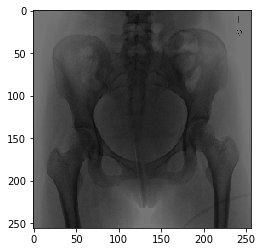

In [12]:
# test
import dicom
import numpy as np
# import cv2
from scipy.misc import imsave
from scipy.misc import bytescale
from skimage.transform import resize
from skimage import exposure
from skimage import io,data,color
ds = dicom.read_file('/home/bw/DeepLearning/female/train/32152551')
pixel_array = ds.pixel_array
# im = cv2.resize(pixel_array,(256,256),interpolation=cv2.INTER_CUBIC)
# im = color.gray2rgb(im)
# im = resizeDicomArray(pixel_array)
# im = np.reshape(pixel_array, (256, 256, 3))
# im = cv2.cvtColor(resizeDicomArray(pixel_array),cv2.COLOR_GRAY2BGR)
# im = cv2.convertScaleAbs(im)
# pixel_array = resize(pixel_array, (256, 256))
# im = (np.dstack((pixel_array,pixel_array,pixel_array)) * 255.999) .astype(np.uint8)
# im = [pixel_array, pixel_array , pixel_array]
# im = cv2.resize(pixel_array,(256,256, 3),interpolation=cv2.INTER_CUBIC)
# print im
# print im.shape
# print type(im[0][0])
showImage(im)

In [ ]:
# test images classification from trained cafffemodel
# following code proved caffe load numpy ndarray
# output <type 'numpy.ndarray'>
#    (256, 256, 3)
# and the show the image
# image = caffe.io.load_image('/home/bw/test.png')
# print type(image)
# print image.shape
# showImage(image)

In [10]:
import dicom
ds = dicom.read_file('/home/bw/data/data/DeepLearning/BoneAge/male/train/32103074')
im = resizeDicomArray(ds.pixel_array)
print im.shape

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(256, 256)


1049


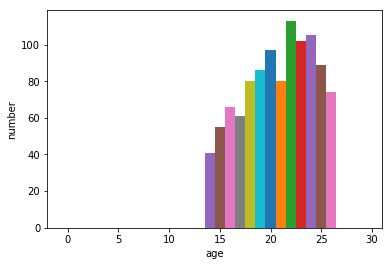

In [13]:
# show the ages statistics
file_list = getFileList('/home/bw/DeepLearning/male/train')
file_list = file_list + getFileList('/home/bw/DeepLearning/male/test')
# file_list = file_list + getFileList('/home/bw/data/data/DeepLearning/BoneAge/female/train')
# file_list = file_list + getFileList('/home/bw/data/data/DeepLearning/BoneAge/female/validation')
ages = []
for file in file_list:
    ages.append(getPaientInfo(file)[1])
print len(ages)
# print ages.count(16)
import matplotlib.pyplot as plt
fig_width = 1  
def showStat(ages):
    dic = {}
    for i in range(30):
        dic[i] = ages.count(i)
    for i in range(30):
        plt.figure(1)
        plt.bar(i*fig_width, dic[i], fig_width)
    plt.xlabel(u"age") 
    plt.ylabel(u"number") 
    plt.show()
showStat(ages)

In [ ]:
file_list = getFileList('/home/bw/data/data/DeepLearning/BoneAge/male/validation')
file_list = file_list + getFileList('/home/bw/data/data/DeepLearning/BoneAge/male/train')
file_list = file_list + getFileList('/home/bw/data/data/DeepLearning/BoneAge/female/train')
file_list = file_list + getFileList('/home/bw/data/data/DeepLearning/BoneAge/female/validation')
for file in file_list:
    ds = dicom.read_file(file)
    showImage(ds.pixel_array)

In [21]:
img = caffe.io.load_image('/home/bw/test.png', color=False)
print type(img)
print img.shape
showImage(img)

<type 'numpy.ndarray'>
(256, 256, 1)


TypeError: Invalid dimensions for image data